## 미션 소개
이번 미션에서는 흉부 X-Ray 사진을 바탕으로 폐렴 환자를 구분하는 작업을 수행합니다. 이번 미션의 목표는 X-Ray 사진을 입력으로 받아 **폐렴 여부를 구분하는 분류(Classification) 모델**을 만드는 것입니다. 아래 데이터셋을 활용하여 **다양한 이미지 전처리 및 증강 기법과 Transfer Learning과 Fine-Tuning 기법을 실험**해보고, 모델의 성능을 평가해 보세요.

**문제 정의**
- 폐렴 진단을 위해 chest X-ray 이미지를 사용하여 VGG16 모델로 이진 분류(폐렴 있음/없음)

Class 0: 정상 (폐렴 없음)

Class 1: 폐렴 있음

### 폐렴
<img src="https://blog.kakaocdn.net/dn/cfMTzQ/btqGAfChgTH/fSaLVcTaEFJCJRw0z0yUG0/img.jpg" width="600"/>

- 폐에 염증이 생기면서 폐에 점액 및 이물질이 차는 질병 

- 폐 공간에 보이는 증가된 불투명도(화이트닝)

## 데이터셋
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [4]:
# chest_xray/
#  ├── train/
#  │    ├── normal/
#  │    └── pneumonia/
#  ├── val/
#  │    ├── normal/
#  │    └── pneumonia/
#  └── test/
#       ├── normal/
#       └── pneumonia/

## PLAN
1. 데이터 준비
 - 데이터 구성: 정상(Normal) vs 폐렴(Pneumonia)

2. 데이터 전처리
 - 이미지 리사이즈 (ex. 224x224)
 - 정규화(Normalization) (ex. pixel value / 255.0)
 - 클래스 불균형 확인 및 조정 (ex. 오버샘플링, 언더샘플링)

3. 데이터 증강 (Augmentation)
 - Random Rotation, Horizontal Flip, Random Zoom, Brightness Adjustment 등
 - torchvision.transforms 또는 keras.preprocessing.image.ImageDataGenerator 사용

4. Transfer Learning 모델 선택
 - 사전 학습된 모델 사용 (ex. ResNet50, EfficientNet, DenseNet121)
 - Imagenet으로 미리 학습된 가중치 불러오기

5. Fine-Tuning 전략
 - Feature Extracting: 마지막 레이어만 학습
 - Full Fine-Tuning: 전체 레이어를 미세 조정

6. 모델 학습
 - 적절한 손실 함수 (ex. Binary CrossEntropy)
 - 최적화 기법 (Adam, SGD 등)
 - Early Stopping, Learning Rate Scheduler 사용

7. 성능 평가
 - Accuracy, Precision, Recall, F1-score
 - Confusion Matrix
 - ROC Curve, AUC Score

8. 최종 결과 정리
 - 실험 비교 (전처리/증강 적용 전후, Transfer Learning 적용 전후 등)
 - Best Model 선정

### CrossEntropyLoss vs. BCEWithLogitsLoss
| 항목 | `nn.CrossEntropyLoss()` | `nn.BCEWithLogitsLoss()` |
|------|--------------------------|----------------------------|
| 사용 목적 | **다중 클래스 분류 (multi-class)** | **이진 분류 (binary)** 혹은 **다중 레이블 분류 (multi-label)** |
| 입력 형태 | **로짓(logits)**, shape: `(N, C)`<br>(C는 클래스 수, 정답은 정수 인덱스) | **로짓(logits)**, shape: `(N, 1)` or `(N,)`<br>(정답은 0 또는 1 실수값) |
| 정답 형태 | 정수형 클래스 레이블 (`0`, `1`, `2`, ...) | 부동소수점 확률값 (`0.0` 또는 `1.0`) |
| 내부 처리 | softmax + log + NLLLoss | sigmoid + binary cross-entropy |

In [4]:
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import cv2
from PIL import Image, ImageEnhance, ImageFilter
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split

from torchvision import transforms
from torchvision.transforms import v2
import math
import torchvision.transforms.functional as TF
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torchinfo import summary

import warnings
warnings.filterwarnings('ignore')

In [5]:
# 현재 실행 환경에서 GPU가 사용 가능한지 확인한 후, 그에 맞는 장치를 선택하기 위함
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
# 경로 설정
train_dir = './chest_xray/train/'
train_normal_dir = os.path.join(train_dir, 'normal')
train_pneumonia_dir = os.path.join(train_dir, 'pneumonia')

val_dir = './chest_xray/val/'
val_normal_dir = os.path.join(val_dir, 'normal')
val_pneumonia_dir = os.path.join(val_dir, 'pneumonia')

test_dir = './chest_xray/test/'
test_normal_dir = os.path.join(test_dir, 'normal')
test_pneumonia_dir = os.path.join(test_dir, 'pneumonia')

In [12]:
# 클래스별 이미지 개수 확인 함수 정의
def count_img(folder):
    normal_count = len(os.listdir(os.path.join(folder, 'normal')))
    pneumonia_count = len(os.listdir(os.path.join(folder, 'pneumonia')))
    total_count = normal_count + pneumonia_count
    return normal_count, pneumonia_count, total_count

In [14]:
train_normal_count, train_pneumonia_count, train_total_count = count_img(train_dir)
val_normal_count, val_pneumonia_count, val_total_count = count_img(val_dir)
test_normal_count, test_pneumonia_count, test_total_count = count_img(test_dir)

print("Number of image data by class")
print(f"<Train> | Normal : {train_normal_count} | Pneumonia : {train_pneumonia_count} | total : {train_total_count}")
print(f"<val>   | Normal : {val_normal_count}    | Pneumonia : {val_pneumonia_count}    | total : {val_total_count}")
print(f"<test>  | Normal : {test_normal_count}  | Pneumonia : {test_pneumonia_count}  | total : {test_total_count}")

Number of image data by class
<Train> | Normal : 1341 | Pneumonia : 3875 | total : 5216
<val>   | Normal : 8    | Pneumonia : 8    | total : 16
<test>  | Normal : 234  | Pneumonia : 390  | total : 624


In [16]:
# 데이터프레임 생성
df = pd.DataFrame({
    'Dataset': ['Train', 'Train', 'Validation', 'Validation', 'Test', 'Test'],
    'Class': ['Normal', 'Pneumonia', 'Normal', 'Pneumonia', 'Normal', 'Pneumonia'],
    'Count': [train_normal_count, train_pneumonia_count, val_normal_count, val_pneumonia_count, test_normal_count, test_pneumonia_count]
})

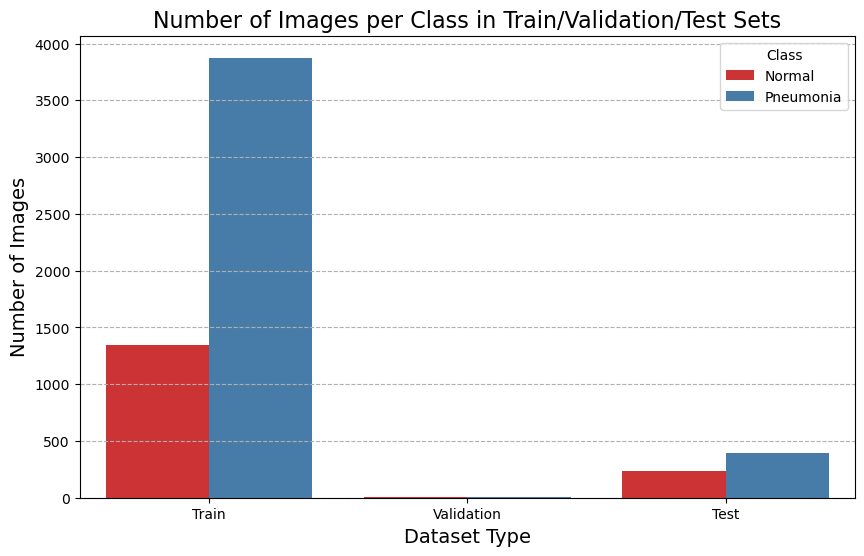

In [18]:
# 시각화
plt.figure(figsize=(10,6))
sns.barplot(x='Dataset', y='Count', hue='Class', data=df, palette='Set1')
plt.title('Number of Images per Class in Train/Validation/Test Sets', fontsize=16)
plt.xlabel('Dataset Type', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.legend(title='Class')
plt.grid(axis='y', linestyle='--')
plt.show()

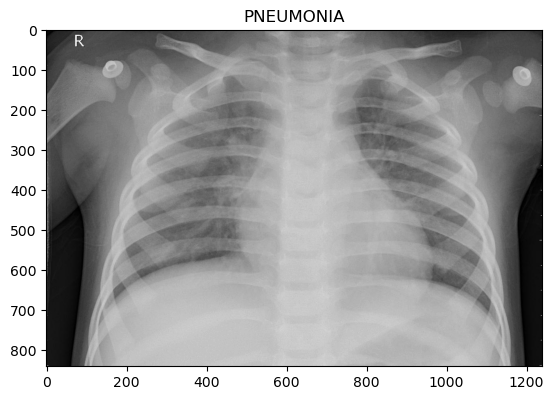

In [13]:
# 이미지 시각화
img_path = os.path.join(train_dir,"./PNEUMONIA/person1_bacteria_2.jpeg")
img = Image.open(img_path)
plt.imshow(img, cmap='gray')
plt.title('PNEUMONIA')
plt.show()

In [14]:
def display_sample_images(directory, category, n=5):
    cat_path = os.path.join(directory, category)
    image_files = glob(os.path.join(cat_path, "*.jpeg"))
    
    plt.figure(figsize=(25,5))
    for i, img_path in enumerate(image_files[:n]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.title(category)
        plt.axis("off")
    plt.show()

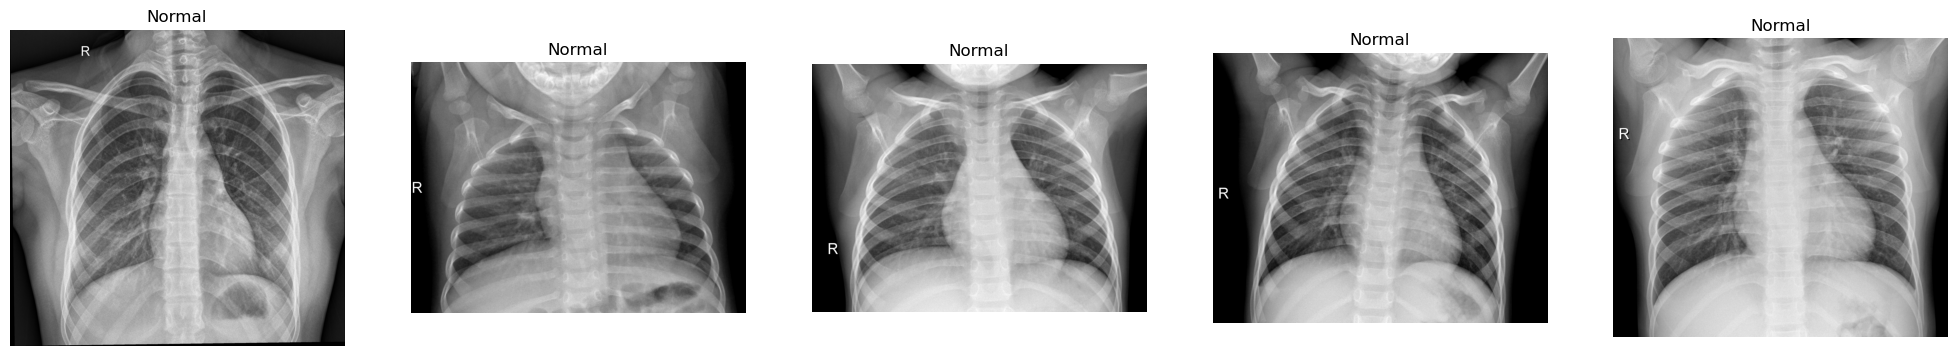

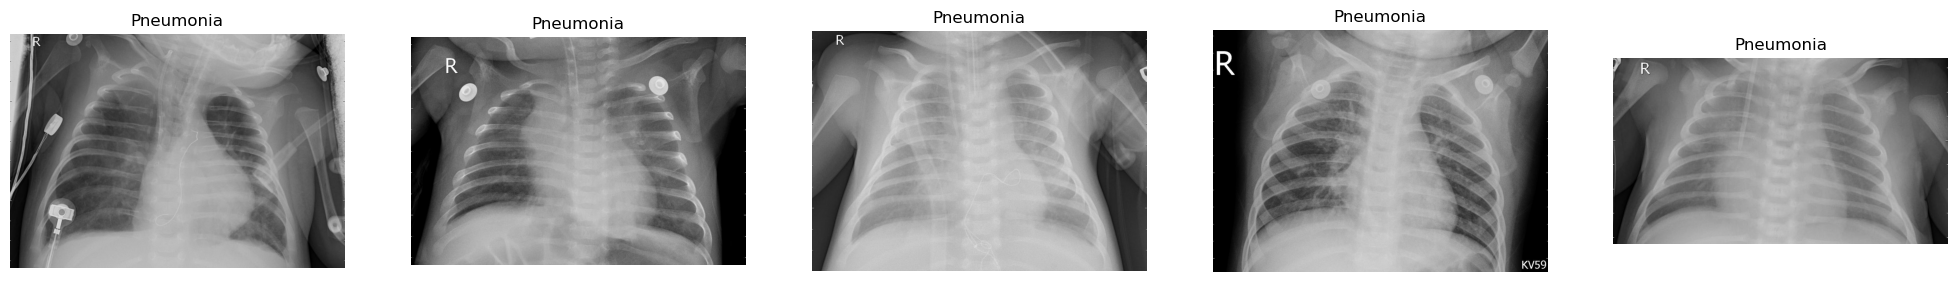

In [15]:
for category in ["Normal", "Pneumonia"]:
    display_sample_images(train_dir, category)

In [16]:
# 이미지 shape 분포 확인
images_shape = []

# glob(train_dir + "*/*") : train_dir 아래에 있는 모든 클래스의 폴더 안에 있는 이미지 파일들의 경로 전부를 가져옴
for k, image_path in enumerate(glob(train_dir + "*/*")):
    image = Image.open(image_path)    # 각 이미지 파일을 열어서 PIL.Image 객체로 읽어옴
    # image.size : (width, height) 튜플로 가져옴
    # images_shape.append(image.size) : 모든 이미지의 (width, height)를 리스트에 저장
    images_shape.append(image.size)

# 이미지 크기 데이터 프레임 생성
images_shape_df = pd.DataFrame(data = images_shape, columns = ['W', 'H'], dtype='object')
images_shape_df['Size'] = '[' + images_shape_df['W'].astype(str) + ',' + images_shape_df['H'].astype(str) + ']'

In [17]:
len(list(images_shape_df['Size'].unique()))

4366

In [18]:
shape_counts = images_shape_df['Size'].value_counts()
print(shape_counts.head(10))

Size
[1072,648]    7
[1080,728]    6
[1008,680]    5
[1216,872]    5
[976,672]     5
[1064,760]    5
[992,592]     5
[1008,704]    5
[920,544]     4
[1072,664]    4
Name: count, dtype: int64


# 데이터 전처리 및 증강

In [20]:
# 데이터 증강을 위한 이미지 transform 정의
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),                  # 통일된 입력 사이즈
    transforms.RandomHorizontalFlip(p=0.5),         # 좌우 반전 (X-ray는 좌우 반전이 의미에 큰 영향을 주지 않는 경우가 많음)
    transforms.RandomRotation(degrees=10),          # ±10도 내외의 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # 밝기/대비 조절
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # [-1,1] 정규화
])

In [22]:
# validation / test transform 정의
val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

: train 용 변환기와 test 용 변환기를 생성했다. 이미지를 시각화했을 때 이미지의 가로/세로 크기가 일정하지 않아 Resize를 통해 이미지 크기를 일정하게 조정했다.

# 데이터셋 및 데이터로더 생성

#### ImageFolder
- 로컬에 저장된 이미지 데이터를 불러올 때 사용하는 pytorch 라이브러리
- ImageFolder를 이용하면 이미지들이 각 class에 해당하는 폴더에 각각 나누어져 있을 때 이를 dataset 형태로 쉽게 불러올 수 있음.
- ImageFolder(root, transform, target_transform, loader, is_valid_file)
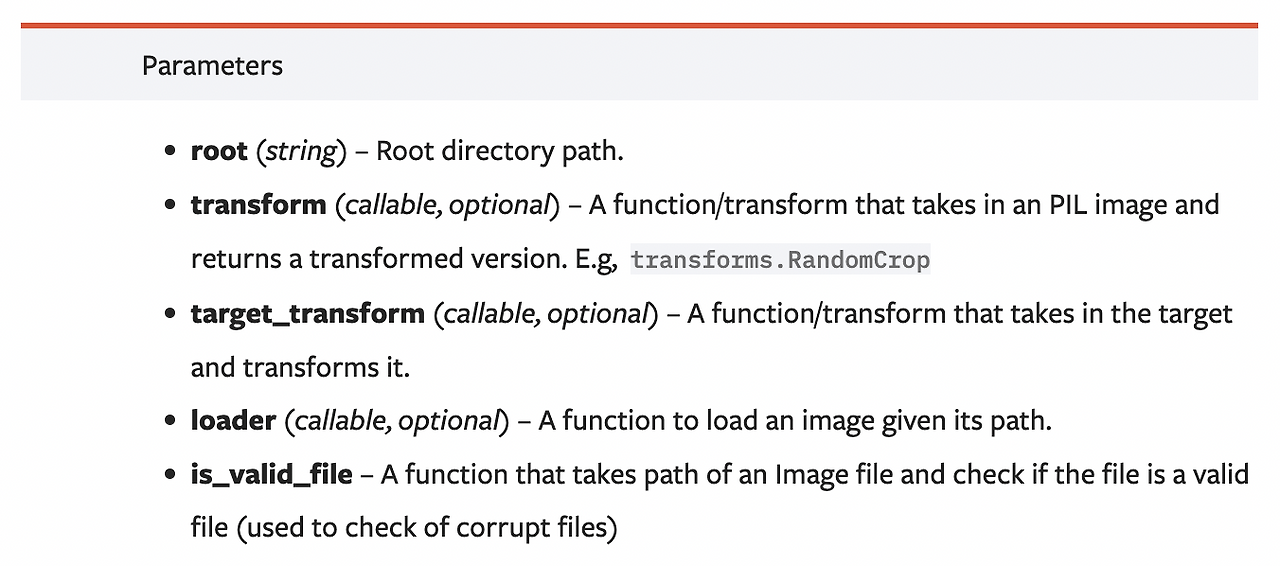

In [24]:
# ImageFolder로 데이터셋 생성
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
val_dataset = ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = ImageFolder(root=test_dir, transform=val_test_transform)

In [26]:
len(train_dataset), len(val_dataset), len(test_dataset)

(5216, 16, 624)

In [28]:
# DataLoader로 배치 단위 불러오기
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [30]:
# 클래스 이름 확인
print(f"클래스: {train_dataset.classes}")
print(f"클래스 인덱스 매핑: {train_dataset.class_to_idx}")

클래스: ['NORMAL', 'PNEUMONIA']
클래스 인덱스 매핑: {'NORMAL': 0, 'PNEUMONIA': 1}


# CNN

In [30]:
class CNN_Pneumonia(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),   # 1*224*224 → 16*224*224
            nn.ReLU(),  
            nn.MaxPool2d(2),                              # 16*112*112

            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # 16*112*112 → 32*112*112
            nn.ReLU(),
            nn.MaxPool2d(2),                              # 32*56*56

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 32*56*56 → 64*56*56
            nn.ReLU(),
            nn.MaxPool2d(2),                              # 64*28*28

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 64*28*28 → 128*28*28
            nn.ReLU(),
            nn.MaxPool2d(2),                              # 128*14*14
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # 입력 이미지가 224x224이라 가정 
            nn.Linear(128 * 14 * 14, 256),  # 128*14*14 → 256
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),  # 이진 분류: 폐렴 or 정상  # 256 → 1
            nn.Sigmoid()    # [0~1 확률]
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [31]:
model_CNN = CNN_Pneumonia().to(device)

이전 프로젝트에서는 손실함수로 nn.CrossEntropyLoss()를 사용했지만 nn.CrossEntropyLoss()는 다중 클래스 분류 (multi-class classification)용 이기에 다른 것을 사용했다.

이 프로젝트는 폐렴 질병 여부를 판단하는 이진 분류를 해야하므로 nn.BCELoss() 또는 nn.BCEWithLogitsLoss()를 사용하였다. 이 두 개는 sigmoid를 사용의 유무에 따라 사용해야한다.

In [33]:
summary(model_CNN, input_size=(1, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Pneumonia                            [1, 1]                    --
├─Sequential: 1-1                        [1, 128, 14, 14]          --
│    └─Conv2d: 2-1                       [1, 16, 224, 224]         160
│    └─ReLU: 2-2                         [1, 16, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 16, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         4,640
│    └─ReLU: 2-5                         [1, 32, 112, 112]         --
│    └─MaxPool2d: 2-6                    [1, 32, 56, 56]           --
│    └─Conv2d: 2-7                       [1, 64, 56, 56]           18,496
│    └─ReLU: 2-8                         [1, 64, 56, 56]           --
│    └─MaxPool2d: 2-9                    [1, 64, 28, 28]           --
│    └─Conv2d: 2-10                      [1, 128, 28, 28]          73,856
│    └─ReLU: 2-11                        [1, 128, 28, 28]          --
│  

In [34]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        # 미니배치 데이터를 GPU/CPU로 이동하고, labels의 형태를 [batch_size, 1]로 변경
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            # 모델을 통해 예측값 생성 후, 손실 계산
            outputs = model(images)
            loss = criterion(outputs, labels)
            # 기존 기울기를 초기화하고(backpropagation), 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            # 출력이 0.5보다 크면 1로, 아니면 0으로 변환한 뒤 정답과 비교 → 정확도 계산용
            # outputs > 0.5
            # outputs = sigmoid 함수의 결과 (범위 0~1)
            # 0.5를 기준으로 '>0.5': 양성 클래스(1) / '<= 0.5': 음성 클래스(0)
            # soft prediction (확률) → hard prediction (0 또는 1)으로 변환
            # --------------------------------------------------------
            # Boolean 결과를 float로 변환 (True → 1.0, False → 0.0)
            # labels와 비교할 수 있도록 같은 자료형으로 맞춰줌
            preds = (outputs > 0.5).float()

            # 예측이 정답과 일치한 개수 합산
            # .item()은 파이토치 텐서를 Python 숫자로 변환 (정확도 계산을 위해 필요)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # 평균 손실과 정확도 계산
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        # 평가 모드로 설정하고, 기울기 계산 비활성화로 메모리 절약 및 속도 향상
        # 검증 과정은 훈련과 거의 동일하지만, optimizer 관련 코드가 없음
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = (outputs > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_CNN = CNN_Pneumonia().to(device)

In [36]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)
epochs = 10

In [37]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model_CNN, train_loader, val_loader, loss_fn, optimizer, epochs, device
)

Epoch [1/10] - Train Loss: 0.2791, Acc: 0.8838 | Val Loss: 0.7114, Acc: 0.6250
Epoch [2/10] - Train Loss: 0.1494, Acc: 0.9465 | Val Loss: 0.8976, Acc: 0.7500
Epoch [3/10] - Train Loss: 0.1251, Acc: 0.9546 | Val Loss: 0.7598, Acc: 0.6875
Epoch [4/10] - Train Loss: 0.1260, Acc: 0.9513 | Val Loss: 0.6314, Acc: 0.6875
Epoch [5/10] - Train Loss: 0.1044, Acc: 0.9638 | Val Loss: 0.4274, Acc: 0.7500
Epoch [6/10] - Train Loss: 0.0940, Acc: 0.9640 | Val Loss: 0.4692, Acc: 0.7500
Epoch [7/10] - Train Loss: 0.1680, Acc: 0.9657 | Val Loss: 0.3376, Acc: 0.7500
Epoch [8/10] - Train Loss: 0.0955, Acc: 0.9668 | Val Loss: 0.3310, Acc: 0.8125
Epoch [9/10] - Train Loss: 0.0802, Acc: 0.9709 | Val Loss: 0.4145, Acc: 0.8125
Epoch [10/10] - Train Loss: 0.0746, Acc: 0.9709 | Val Loss: 0.6802, Acc: 0.6250


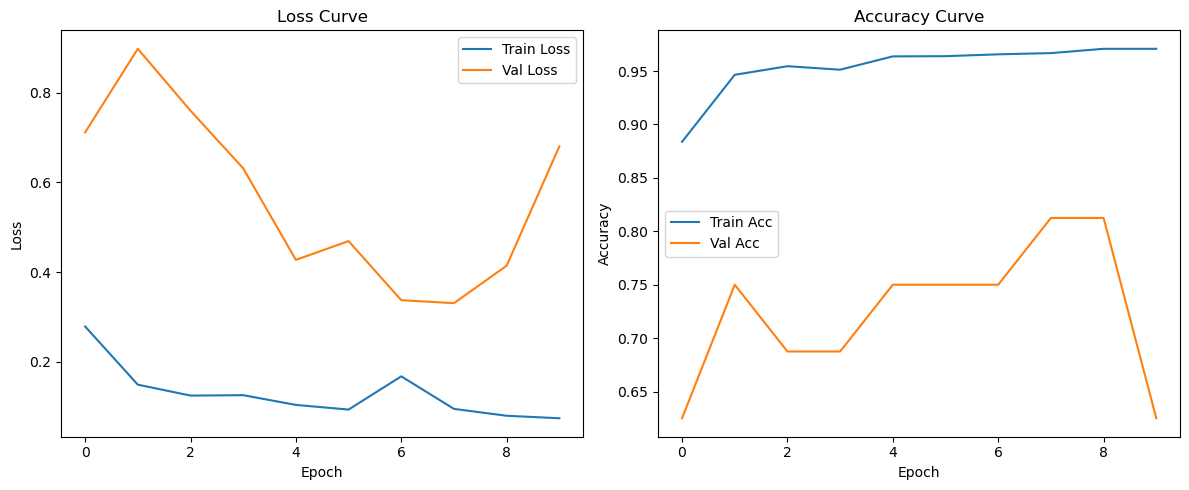

In [42]:
# Loss 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
def evaluate_model(model, test_loader, loss_fn, device):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = test_loss / len(test_loader)
    accuracy = correct / total
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy

In [50]:
# 학습 이후 평가
test_loss, test_acc = evaluate_model(model_CNN, test_loader, loss_fn, device)

Test Loss: 1.3015, Test Accuracy: 0.7516


In [54]:
# 예측 결과 수집 함수 정의
def get_predictions_and_labels(model, data_loader, device):
    model.eval()

    # y_true: 실제 정답 라벨들
    # y_pred: 모델이 출력한 예측 라벨들 (0 또는 1)
    # y_scores: 모델의 출력 확률값 (sigmoid 통과 후), ROC/PR 커브에 사용
    y_true, y_pred, y_scores = [], [], []

    # 평가 시에는 역전파(gradient 계산)이 필요 없기 때문에 torch.no_grad()를 사용하면 속도와 메모리 사용량이 개선
    with torch.no_grad():
        # 배치 단위로 데이터 추론
        for images, labels in data_loader:
            images = images.to(device)
            # .unsqueeze(1): (batch_size,) 형태를 (batch_size, 1)로 바꿔 모델 출력 형태와 일치시킴
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            # torch.sigmoid: 로짓 값을 확률(0~1)로 변환합니다. 이진 분류에서 꼭 필요
            probs = torch.sigmoid(outputs)  # 확률값
            preds = (probs > 0.5).float()   # 이진 분류

            # extend()를 통해 하나의 리스트에 모든 배치 데이터를 계속 추가
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    return y_true, y_pred, y_scores

In [70]:
y_true, y_pred, y_scores = get_predictions_and_labels(model_CNN, test_loader, device)

In [61]:
# Confusion Matrix 시각화
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names=["Negative", "Positive"]):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

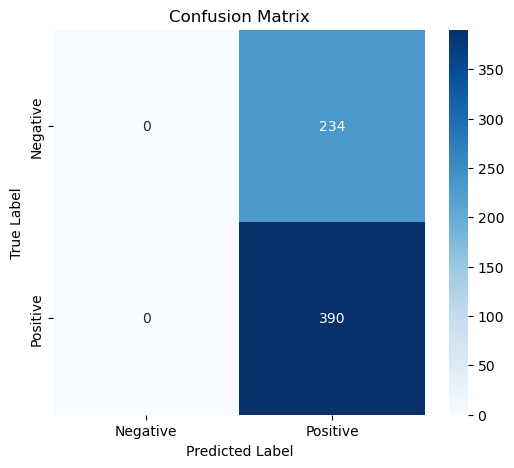

In [79]:
plot_confusion_matrix(y_true, y_pred)

- **FP (False Positive) = 234**: 실제 음성인데 모델이 양성으로 잘못 예측한 경우이다. **오탐지가 많다**는 것을 의미
- **FN (False Negative)** = 0: 실제 양성인 경우 모델은 양성으로 예측한 적이 없다. 즉, 모든 양성 사례를 정확히 예측했다는 의미
- **TP (True Positive)** = 390: 실제 양성인 경우 모델이 정확히 양성으로 예측한 경우

In [63]:
# ROC Curve 시각화
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=0.7)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

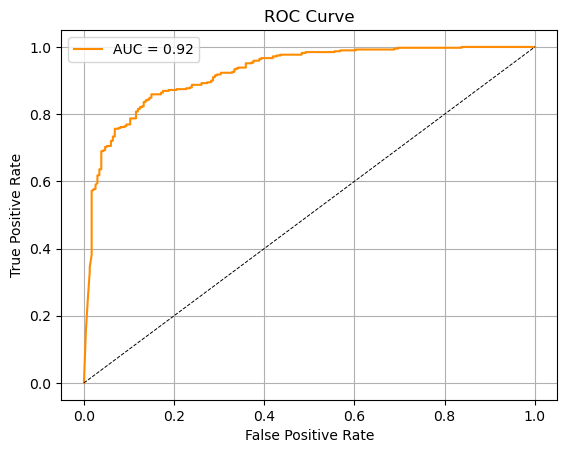

In [85]:
plot_roc_curve(y_true, y_scores)

AUC 값은 0과 1 사이에서 평가된다. 이 모델은 0.92로 매우 우수한 성능을 가지고 양성 클래스와 음성 클래스를 잘 구분하고 있다는 것을 의미한다.

하지만 Confusion Matrix에서 TN=0인 점을 보면, 모델이 모든 음성을 양성으로 잘못 예측하고 있다. 이 경우, 모델이 음성 클래스를 제대로 예측하지 못하고 모든 음성을 양성으로 예측하고 있다는 것을 알 수 있다.

즉, AUC가 높지만 실제 성능은 좋다고 보기 어렵다.

In [65]:
# Precision-Recall Curve 및 F1-score 출력
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report

def plot_PR_and_classification_report(y_true, y_pred, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)

    plt.figure()
    plt.plot(recall, precision, label=f"Avg Precision = {avg_precision:.2f}", color='green')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

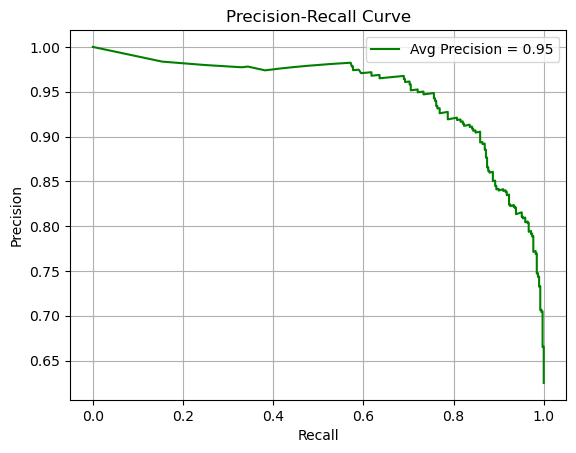

Classification Report:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       234
         1.0     0.6250    1.0000    0.7692       390

    accuracy                         0.6250       624
   macro avg     0.3125    0.5000    0.3846       624
weighted avg     0.3906    0.6250    0.4808       624



/opt/anaconda3/envs/yolov5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/yolov5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/yolov5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
plot_PR_and_classification_report(y_true, y_pred, y_scores)

**Precision (정밀도)**
- 0 클래스는 0.0000, 즉 정밀도가 매우 낮음 / 이는 모델이 음성을 양성으로 예측한 경우가 많다는 것을 의미한다. 음성을 양성으로 잘못 예측하는 일이 많으므로, 정밀도가 0에 가까운 값이다.
- 1 클래스는 0.6250, 즉 모델이 양성으로 예측한 경우 중 62.5%만 실제 양성인 경우이다. / 이는 모델이 양성 클래스를 예측할 때 오탐지를 많이 한다는 것을 의미한다.

**Recall (재현율)**
- 0 클래스는 0.0000, 즉 모델이 **음성 사례를 전혀 잡지 못함**을 나타낸다. 모든 음성을 양성으로 예측하고 있기 때문
- 1 클래스는 1.0000, 즉 **모든 양성 사례를 완벽하게 예측**했다고 볼 수 있다. 이는 모델이 양성 클래스에 대해서는 매우 정확하다는 의미이다.

**F1-Score**
- 0 클래스는 0.0000, F1-score가 0인 이유는 정밀도와 재현율이 모두 0이기 때문이다. 음성 클래스에서 모델이 제대로 예측하지 못하고 있다는 것을 의미한다.
- 1 클래스는 0.7692, 양성 클래스에서 상당히 괜찮은 성능을 보이지만, 정밀도와 재현율이 이상적으로 높지 않아서 완벽한 모델이라고는 할 수 없다.

**Accuracy = 0.6250**
- 이는 모델이 모든 음성을 양성으로 예측한 결과여서 정확도가 높은 것처럼 보이지만, 실제로 모델은 음성을 전혀 예측하지 못하고 있는 문제가 있다. 즉, 모델이 '양성만 예측하는' 특성을 가진 상태라서 이 정확도는 매우 불완전한 성과이다.

## CNN 모델 중간 결론

모델이 양성 클래스에 대해서는 잘 작동하지만, 음성 클래스에 대한 예측이 전혀 이루어지지 않는 문제가 있다.

데이터 불균형 문제를 해결하고, 모델이 음성 클래스도 예측할 수 있도록 개선이 필요하다고 생각한다.

--> 시도 해볼 만한 해결법 : Threshold 낮추기

## CNN 모델 수정 : Threshold=0.2 으로 변경

In [157]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        # 미니배치 데이터를 GPU/CPU로 이동하고, labels의 형태를 [batch_size, 1]로 변경
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            # 모델을 통해 예측값 생성 후, 손실 계산
            outputs = model(images)
            loss = criterion(outputs, labels)
            # 기존 기울기를 초기화하고(backpropagation), 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            # 출력이 0.5보다 크면 1로, 아니면 0으로 변환한 뒤 정답과 비교 → 정확도 계산용
            # outputs > 0.5
            # outputs = sigmoid 함수의 결과 (범위 0~1)
            # 0.5를 기준으로 '>0.5': 양성 클래스(1) / '<= 0.5': 음성 클래스(0)
            # soft prediction (확률) → hard prediction (0 또는 1)으로 변환
            # --------------------------------------------------------
            # Boolean 결과를 float로 변환 (True → 1.0, False → 0.0)
            # labels와 비교할 수 있도록 같은 자료형으로 맞춰줌
            preds = (outputs > 0.5).float()

            # 예측이 정답과 일치한 개수 합산
            # .item()은 파이토치 텐서를 Python 숫자로 변환 (정확도 계산을 위해 필요)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # 평균 손실과 정확도 계산
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        # 평가 모드로 설정하고, 기울기 계산 비활성화로 메모리 절약 및 속도 향상
        # 검증 과정은 훈련과 거의 동일하지만, optimizer 관련 코드가 없음
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = (outputs > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [159]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_CNN_t3 = CNN_Pneumonia().to(device)

In [161]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model_CNN_t3.parameters(), lr=0.001)
epochs = 10

In [163]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model_CNN_t3, train_loader, val_loader, loss_fn, optimizer, epochs, device
)

Epoch [1/10] - Train Loss: 0.3219, Acc: 0.8648 | Val Loss: 0.9562, Acc: 0.5000
Epoch [2/10] - Train Loss: 0.1725, Acc: 0.9388 | Val Loss: 0.6282, Acc: 0.5625
Epoch [3/10] - Train Loss: 0.1468, Acc: 0.9482 | Val Loss: 0.3018, Acc: 0.6250
Epoch [4/10] - Train Loss: 0.1177, Acc: 0.9584 | Val Loss: 0.4405, Acc: 0.6250
Epoch [5/10] - Train Loss: 0.1094, Acc: 0.9618 | Val Loss: 0.4583, Acc: 0.6250
Epoch [6/10] - Train Loss: 0.1009, Acc: 0.9638 | Val Loss: 0.6774, Acc: 0.5625
Epoch [7/10] - Train Loss: 0.1024, Acc: 0.9638 | Val Loss: 0.4205, Acc: 0.5625
Epoch [8/10] - Train Loss: 0.0984, Acc: 0.9653 | Val Loss: 0.3843, Acc: 0.6250
Epoch [9/10] - Train Loss: 0.0858, Acc: 0.9691 | Val Loss: 0.6637, Acc: 0.5625
Epoch [10/10] - Train Loss: 0.0871, Acc: 0.9680 | Val Loss: 0.7645, Acc: 0.6250


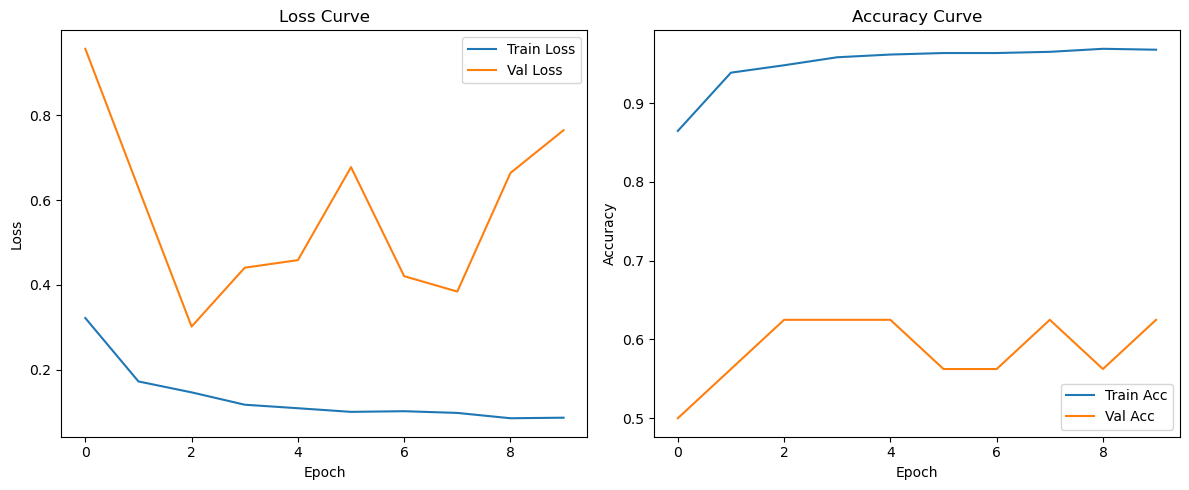

In [164]:
# Loss 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [166]:
def evaluate_model(model, test_loader, loss_fn, device):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = test_loss / len(test_loader)
    accuracy = correct / total
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy

In [167]:
# 학습 이후 평가
test_loss, test_acc = evaluate_model(model_CNN_t3, test_loader, loss_fn, device)

Test Loss: 1.3166, Test Accuracy: 0.7260


In [59]:
# 예측 결과 수집 함수 정의
def get_predictions_and_labels(model, data_loader, device):
    model.eval()

    # y_true: 실제 정답 라벨들
    # y_pred: 모델이 출력한 예측 라벨들 (0 또는 1)
    # y_scores: 모델의 출력 확률값 (sigmoid 통과 후), ROC/PR 커브에 사용
    y_true, y_pred, y_scores = [], [], []

    # 평가 시에는 역전파(gradient 계산)이 필요 없기 때문에 torch.no_grad()를 사용하면 속도와 메모리 사용량이 개선
    with torch.no_grad():
        # 배치 단위로 데이터 추론
        for images, labels in data_loader:
            images = images.to(device)
            # .unsqueeze(1): (batch_size,) 형태를 (batch_size, 1)로 바꿔 모델 출력 형태와 일치시킴
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            # torch.sigmoid: 로짓 값을 확률(0~1)로 변환합니다. 이진 분류에서 꼭 필요
            probs = torch.sigmoid(outputs)  # 확률값
            preds = (probs > 0.2).float()   # 이진 분류

            # extend()를 통해 하나의 리스트에 모든 배치 데이터를 계속 추가
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    return y_true, y_pred, y_scores

In [169]:
# 학습 이후 평가
test_loss, test_acc = evaluate_model(model_CNN_t3, test_loader, loss_fn, device)

Test Loss: 1.3166, Test Accuracy: 0.7260


In [170]:
y_true, y_pred, y_scores = get_predictions_and_labels(model_CNN_t3, test_loader, device)

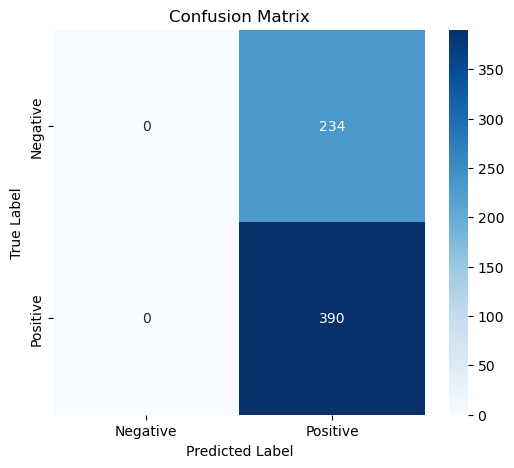

In [171]:
plot_confusion_matrix(y_true, y_pred)

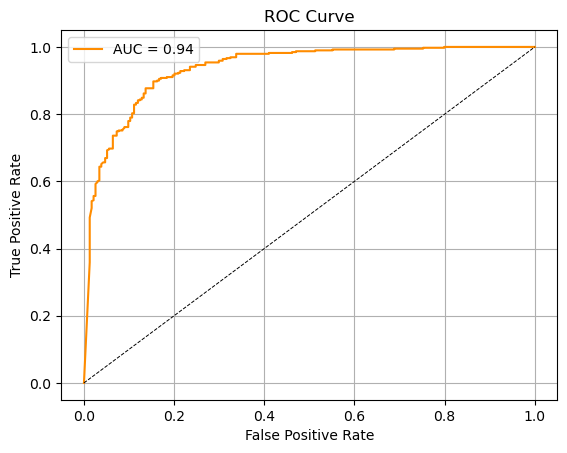

In [172]:
plot_roc_curve(y_true, y_scores)

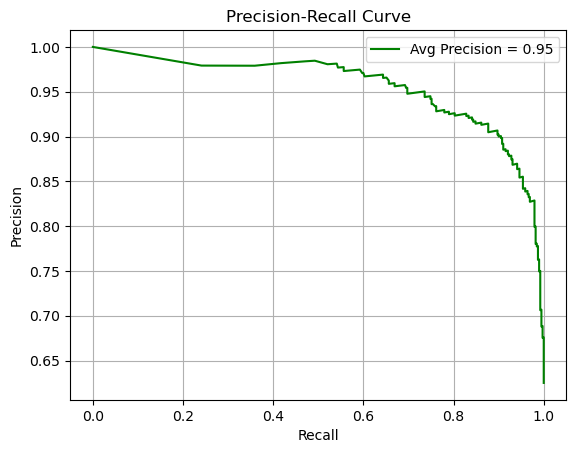

Classification Report:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       234
         1.0     0.6250    1.0000    0.7692       390

    accuracy                         0.6250       624
   macro avg     0.3125    0.5000    0.3846       624
weighted avg     0.3906    0.6250    0.4808       624



/opt/anaconda3/envs/yolov5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/yolov5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/yolov5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [173]:
plot_PR_and_classification_report(y_true, y_pred, y_scores)

## CNN 모델 수정 : Batch_size=16 / BCEWithLogitsLoss()

In [32]:
class CNN_Pneumonia_BWL(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),   # 1 * 224 * 224 → 16 * 224 * 224
            nn.ReLU(),  
            nn.MaxPool2d(2),                              # 16 * 112 * 112

            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # 16 * 112 * 112 → 32 * 112 * 112
            nn.ReLU(),
            nn.MaxPool2d(2),                              # 32 * 56 * 56

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 32 * 56 * 56 → 64 * 56 * 56
            nn.ReLU(),
            nn.MaxPool2d(2),                              # 64 * 28 * 28

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 64 * 28 * 28 → 128 * 28 * 28
            nn.ReLU(),
            nn.MaxPool2d(2),                              # 128 * 14 * 14
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # 입력 이미지가 224x224이라 가정 
            nn.Linear(128 * 14 * 14, 256),  # 128 * 14 * 14 → 256
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),  # 이진 분류: 폐렴 or 정상  # 256 → 1
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [34]:
model_CNN_BWL = CNN_Pneumonia_BWL().to(device)

In [36]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_CNN_BWL.parameters(), lr=0.001)
epochs = 10

In [38]:
summary(model_CNN_BWL, input_size=(1, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Pneumonia_BWL                        [1, 1]                    --
├─Sequential: 1-1                        [1, 128, 14, 14]          --
│    └─Conv2d: 2-1                       [1, 16, 224, 224]         160
│    └─ReLU: 2-2                         [1, 16, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 16, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         4,640
│    └─ReLU: 2-5                         [1, 32, 112, 112]         --
│    └─MaxPool2d: 2-6                    [1, 32, 56, 56]           --
│    └─Conv2d: 2-7                       [1, 64, 56, 56]           18,496
│    └─ReLU: 2-8                         [1, 64, 56, 56]           --
│    └─MaxPool2d: 2-9                    [1, 64, 28, 28]           --
│    └─Conv2d: 2-10                      [1, 128, 28, 28]          73,856
│    └─ReLU: 2-11                        [1, 128, 28, 28]          --
│  

In [40]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        # 미니배치 데이터를 GPU/CPU로 이동하고, labels의 형태를 [batch_size, 1]로 변경
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            # 모델을 통해 예측값 생성 후, 손실 계산
            outputs = model(images)
            loss = criterion(outputs, labels)
            # 기존 기울기를 초기화하고(backpropagation), 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            # 출력이 0.5보다 크면 1로, 아니면 0으로 변환한 뒤 정답과 비교 → 정확도 계산용
            # outputs > 0.5
            # outputs = sigmoid 함수의 결과 (범위 0~1)
            # 0.5를 기준으로 '>0.5': 양성 클래스(1) / '<= 0.5': 음성 클래스(0)
            # soft prediction (확률) → hard prediction (0 또는 1)으로 변환
            # --------------------------------------------------------
            # Boolean 결과를 float로 변환 (True → 1.0, False → 0.0)
            # labels와 비교할 수 있도록 같은 자료형으로 맞춰줌
            preds = (outputs > 0.5).float()

            # 예측이 정답과 일치한 개수 합산
            # .item()은 파이토치 텐서를 Python 숫자로 변환 (정확도 계산을 위해 필요)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # 평균 손실과 정확도 계산
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        # 평가 모드로 설정하고, 기울기 계산 비활성화로 메모리 절약 및 속도 향상
        # 검증 과정은 훈련과 거의 동일하지만, optimizer 관련 코드가 없음
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = (outputs > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [42]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_CNN_BWL.parameters(), lr=0.001)
epochs = 10

In [44]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model_CNN_BWL, train_loader, val_loader, loss_fn, optimizer, epochs, device
)

Epoch [1/10] - Train Loss: 0.2921, Acc: 0.8687 | Val Loss: 0.3015, Acc: 0.9375
Epoch [2/10] - Train Loss: 0.1551, Acc: 0.9385 | Val Loss: 0.8892, Acc: 0.6875
Epoch [3/10] - Train Loss: 0.1383, Acc: 0.9473 | Val Loss: 0.6685, Acc: 0.7500
Epoch [4/10] - Train Loss: 0.1182, Acc: 0.9569 | Val Loss: 0.9031, Acc: 0.6875
Epoch [5/10] - Train Loss: 0.1048, Acc: 0.9605 | Val Loss: 0.3099, Acc: 0.8750
Epoch [6/10] - Train Loss: 0.0973, Acc: 0.9647 | Val Loss: 1.6091, Acc: 0.6250
Epoch [7/10] - Train Loss: 0.1037, Acc: 0.9599 | Val Loss: 0.6254, Acc: 0.7500
Epoch [8/10] - Train Loss: 0.0920, Acc: 0.9655 | Val Loss: 0.8066, Acc: 0.6250
Epoch [9/10] - Train Loss: 0.0884, Acc: 0.9695 | Val Loss: 1.0295, Acc: 0.6250
Epoch [10/10] - Train Loss: 0.0798, Acc: 0.9699 | Val Loss: 0.3568, Acc: 0.9375


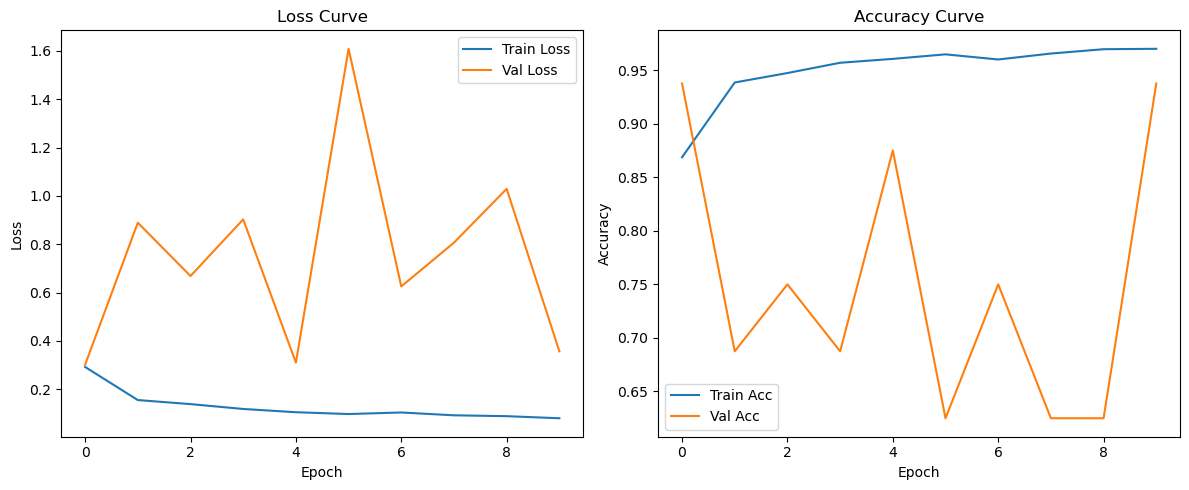

In [45]:
# Loss 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
def evaluate_model(model, test_loader, loss_fn, device):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            preds = (outputs > 0.2).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = test_loss / len(test_loader)
    accuracy = correct / total
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy

In [53]:
# 학습 이후 평가
test_loss, test_acc = evaluate_model(model_CNN_BWL, test_loader, loss_fn, device)

Test Loss: 0.9080, Test Accuracy: 0.7933


In [67]:
y_true, y_pred, y_scores = get_predictions_and_labels(model_CNN_BWL, test_loader, device)

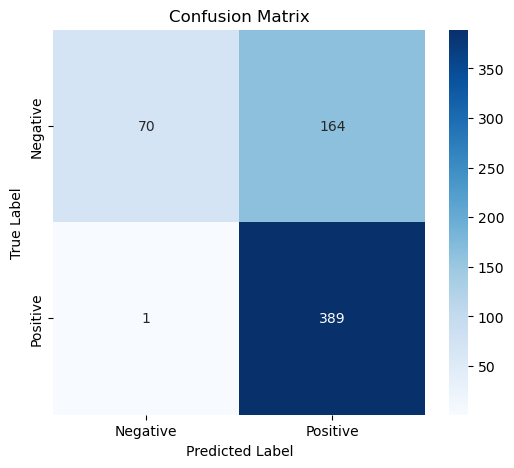

In [68]:
plot_confusion_matrix(y_true, y_pred)

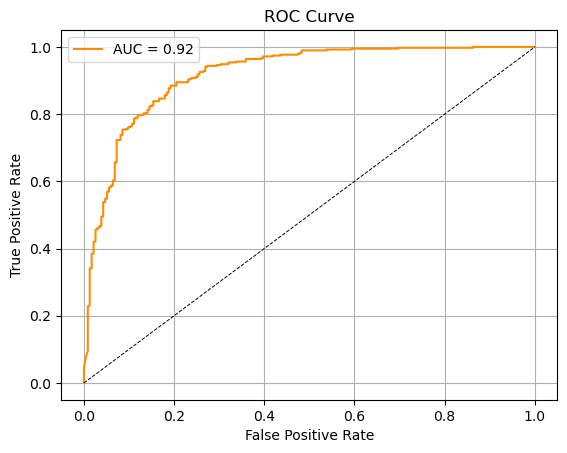

In [69]:
plot_roc_curve(y_true, y_scores)

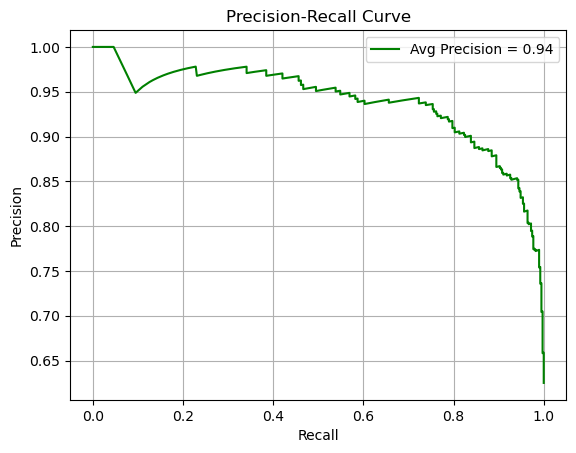

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9859    0.2991    0.4590       234
         1.0     0.7034    0.9974    0.8250       390

    accuracy                         0.7356       624
   macro avg     0.8447    0.6483    0.6420       624
weighted avg     0.8094    0.7356    0.6878       624



In [70]:
plot_PR_and_classification_report(y_true, y_pred, y_scores)

### 해석

**Confusion Matrix 해석**
- True Positive (TP=388): 폐렴을 잘 맞춘 비율이 매우 높음.
- False Negative (FN=2): 폐렴을 놓친 경우가 거의 없음 → 매우 양호.
- False Positive (FP=182): 정상인데 폐렴으로 잘못 예측한 비율이 상당히 많음 → 민감도는 높지만 특이도는 매우 낮음.

**정량적 평가 지표**
1. AUC (Area Under the Curve) = 0.90
- 매우 높은 수치 → 모델이 클래스 간 분류 능력이 뛰어남.
- 하지만 이는 클래스 간 균형이나 Threshold 설정과 관계없는 ROC 기준이므로 실제 운영에서는 한계가 있음.

2. Average Precision = 0.92
- 높은 정밀-재현 곡선 면적 → Positive 클래스(폐렴) 분류에 대한 신뢰도 높음.

**Classification Report 분석**
| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| 0 (정상) | 0.9630 | 0.2222 | 0.3611 | 234 |
| 1 (폐렴) | 0.6807 | 0.9949 | 0.8083 | 390 |

- 정상 (0): Precision은 높지만 Recall이 0.22로 매우 낮음 → 많은 정상 환자를 폐렴으로 오진하고 있음.
- 폐렴 (1): Recall이 0.99로 거의 완벽 → 폐렴을 놓치지 않음.

**<강점>**
- 폐렴 감지는 거의 완벽 (Recall 0.99, FN=2)
- AUC와 Avg Precision이 높아 모델의 전체적인 분류 능력은 우수
- 의료 현장에서는 "폐렴을 놓치지 않는 것"이 중요하므로 높은 Recall은 긍정적

**<문제점>**
- 정상 환자를 폐렴으로 오진 (FP = 182) → 실제 환경에서 과잉 진단 우려 (불필요한 치료나 검사 비용 발생)
- 정상 클래스에 대한 성능 부족 → 데이터 imbalance 또는 손실 함수 설계의 문제일 수 있음

**<결론>**
- 이 모델은 폐렴 탐지에 매우 강한 성능을 보이지만, 정상 판별력이 약해 의료적 실용성에는 제약이 있음.
- Recall 중심의 목표를 달성하고 있지만, FP를 줄이기 위한 후속 개선이 반드시 필요합니다.

## CNN 모델 수정 : Batch_size=16 / nn.BCEWithLogitsLoss()

In [75]:
class CNN_Pneumonia_BWL_07(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),   # 1 * 224 * 224 → 16 * 224 * 224
            nn.ReLU(),  
            nn.MaxPool2d(2),                              # 16 * 112 * 112

            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # 16 * 112 * 112 → 32 * 112 * 112
            nn.ReLU(),
            nn.MaxPool2d(2),                              # 32 * 56 * 56

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 32 * 56 * 56 → 64 * 56 * 56
            nn.ReLU(),
            nn.MaxPool2d(2),                              # 64 * 28 * 28

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 64 * 28 * 28 → 128 * 28 * 28
            nn.ReLU(),
            nn.MaxPool2d(2),                              # 128 * 14 * 14
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # 입력 이미지가 224x224이라 가정 
            nn.Linear(128 * 14 * 14, 256),  # 128 * 14 * 14 → 256
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),  # 이진 분류: 폐렴 or 정상  # 256 → 1
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [79]:
model_CNN_07 = CNN_Pneumonia_BWL_07().to(device)

In [81]:
summary(model_CNN_07, input_size=(1, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Pneumonia_BWL_07                     [1, 1]                    --
├─Sequential: 1-1                        [1, 128, 14, 14]          --
│    └─Conv2d: 2-1                       [1, 16, 224, 224]         160
│    └─ReLU: 2-2                         [1, 16, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 16, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         4,640
│    └─ReLU: 2-5                         [1, 32, 112, 112]         --
│    └─MaxPool2d: 2-6                    [1, 32, 56, 56]           --
│    └─Conv2d: 2-7                       [1, 64, 56, 56]           18,496
│    └─ReLU: 2-8                         [1, 64, 56, 56]           --
│    └─MaxPool2d: 2-9                    [1, 64, 28, 28]           --
│    └─Conv2d: 2-10                      [1, 128, 28, 28]          73,856
│    └─ReLU: 2-11                        [1, 128, 28, 28]          --
│  

In [83]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        # 미니배치 데이터를 GPU/CPU로 이동하고, labels의 형태를 [batch_size, 1]로 변경
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            # 모델을 통해 예측값 생성 후, 손실 계산
            outputs = model(images)
            loss = criterion(outputs, labels)
            # 기존 기울기를 초기화하고(backpropagation), 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            preds = (outputs > 0.7).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # 평균 손실과 정확도 계산
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        # 평가 모드로 설정하고, 기울기 계산 비활성화로 메모리 절약 및 속도 향상
        # 검증 과정은 훈련과 거의 동일하지만, optimizer 관련 코드가 없음
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = (outputs > 0.7).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [85]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_CNN_07.parameters(), lr=0.001)
epochs = 10

In [89]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model_CNN_07, train_loader, val_loader, loss_fn, optimizer, epochs, device
)

Epoch [1/10] - Train Loss: 0.2864, Acc: 0.8660 | Val Loss: 0.5740, Acc: 0.7500
Epoch [2/10] - Train Loss: 0.1539, Acc: 0.9377 | Val Loss: 0.6849, Acc: 0.7500
Epoch [3/10] - Train Loss: 0.1368, Acc: 0.9459 | Val Loss: 0.5352, Acc: 0.8125
Epoch [4/10] - Train Loss: 0.1237, Acc: 0.9530 | Val Loss: 0.4430, Acc: 0.8125
Epoch [5/10] - Train Loss: 0.1141, Acc: 0.9538 | Val Loss: 1.0990, Acc: 0.6250
Epoch [6/10] - Train Loss: 0.1035, Acc: 0.9605 | Val Loss: 0.4595, Acc: 0.6875
Epoch [7/10] - Train Loss: 0.0974, Acc: 0.9626 | Val Loss: 0.6483, Acc: 0.7500
Epoch [8/10] - Train Loss: 0.0903, Acc: 0.9657 | Val Loss: 0.6397, Acc: 0.7500
Epoch [9/10] - Train Loss: 0.0908, Acc: 0.9657 | Val Loss: 0.6541, Acc: 0.7500
Epoch [10/10] - Train Loss: 0.0846, Acc: 0.9655 | Val Loss: 0.4260, Acc: 0.8125


In [105]:
# 학습 이후 평가
test_loss, test_acc = evaluate_model(model_CNN_07, test_loader, loss_fn, device)

Test Loss: 0.7241, Test Accuracy: 0.8061


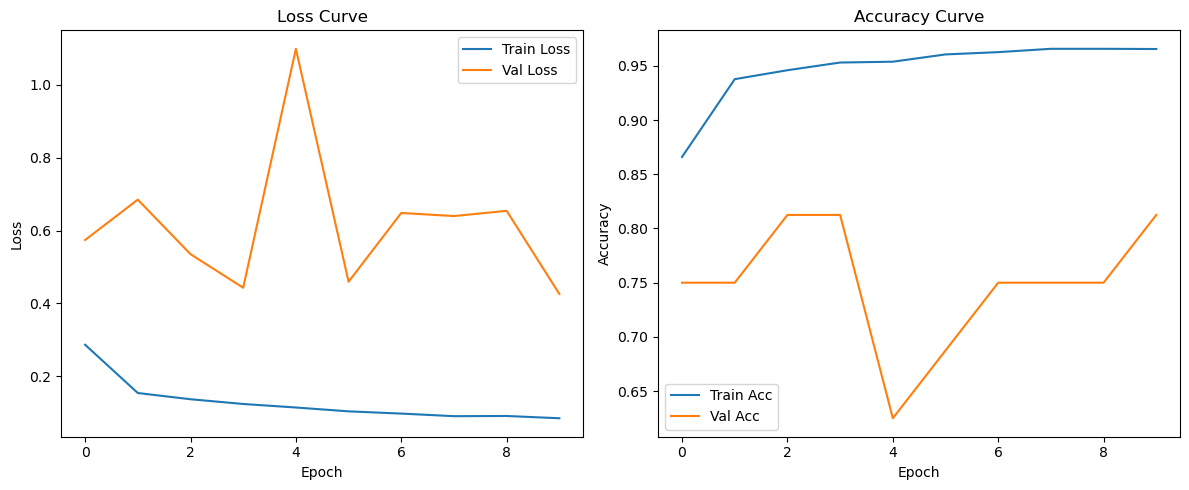

In [90]:
# Loss 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [96]:
y_true, y_pred, y_scores = get_predictions_and_labels(model_CNN_07, test_loader, device)

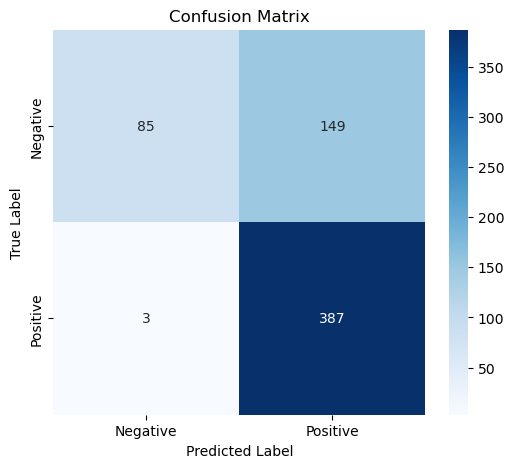

In [97]:
plot_confusion_matrix(y_true, y_pred)

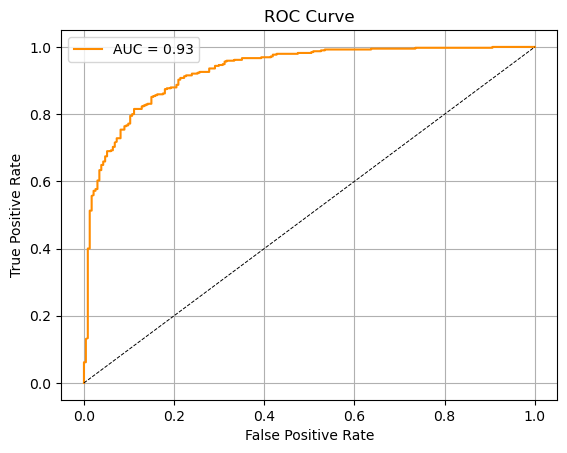

In [98]:
plot_roc_curve(y_true, y_scores)

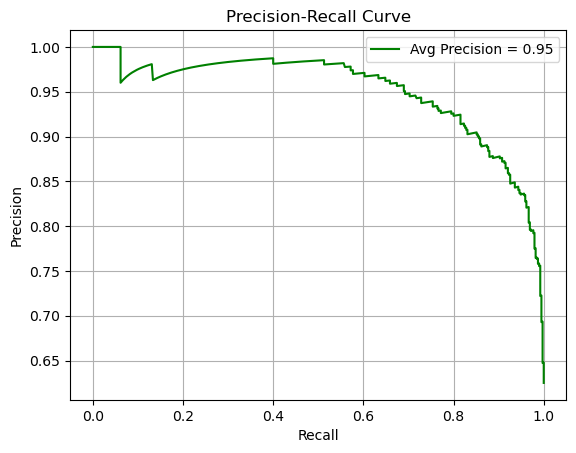

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9659    0.3632    0.5280       234
         1.0     0.7220    0.9923    0.8359       390

    accuracy                         0.7564       624
   macro avg     0.8440    0.6778    0.6819       624
weighted avg     0.8135    0.7564    0.7204       624



In [99]:
plot_PR_and_classification_report(y_true, y_pred, y_scores)

# VGG16

In [402]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, f1_score
import seaborn as sns

In [404]:
# 데이터 전처리 및 데이터 로더 설정 
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # 1채널 이미지를 3채널로 확장
    transforms.ToTensor(),
    # ImageNet에서 학습된 VGG16 모델이 입력받을 이미지를 전처리할 때 사용되는 표준 값들
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [406]:
val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224,224)),                # 이미지를 256x256으로 리사이즈
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # 1채널 이미지를 3채널로 확장
    transforms.ToTensor(),                       # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

In [408]:
train_data = ImageFolder('./data/chest_xray/train', transform=train_transform)
val_data = ImageFolder('./data/chest_xray/val', transform=val_test_transforms)
test_data = ImageFolder('./data/chest_xray/test', transform=val_test_transforms)

In [410]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [412]:
# 흑백 이미지 그대로 사용 (1채널 유지하고 VGG16 구조 수정)
# VGG16의 첫 번째 convolution layer(features[0])를 1채널을 받을 수 있게 수정

# VGG16 모델 로드 및 수정
model_vgg16 = models.vgg16(pretrained=True)  # 사전 학습된 VGG16 모델 불러오기

# 첫 번째 Conv2d 레이어를 1채널 입력용으로 수정 (원래는 in_channels=3)
model_vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

# 마지막 출력층도 이진 분류용으로 수정
model_vgg16.classifier[6] = nn.Linear(4096, 1)

/opt/anaconda3/envs/yolov5/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/yolov5/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [414]:
# 모델을 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg16 = model_vgg16.to(device)

In [416]:
# 손실 함수 및 최적화 설정
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_vgg16.parameters(), lr=0.0001)
epochs=10

In [418]:
# 학습 및 평가 함수 정의
def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs, device):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)  # (batch_size, 1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        print(f"[Epoch {epoch+1}/{epochs}] Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

        # 검증
        model.eval()
        val_loss = 0.0
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

In [420]:
train_model(model_vgg16, train_loader, val_loader, loss_fn, optimizer, epochs, device)

KeyboardInterrupt: 

In [ ]:
y_true, y_pred, y_scores = get_predictions_and_labels(model_vgg16, test_loader, device)

In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
plot_roc_curve(y_true, y_scores)

In [ ]:
plot_PR_and_classification_report(y_true, y_pred, y_scores)

## VGG16 모델 수정: 전이 학습 전략 (Fine-tuning) 조정